In [24]:
import nltk
import pandas as pd
import random
import numpy as np
import string
import math
import networkx as nx

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize

from numpy import array
from collections import Counter
from scipy.sparse import csr_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from gensim import corpora, models, utils
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.models import LsiModel
from gensim.corpora import Dictionary

from gng import GrowingNeuralGas

import re

In [2]:
# Use spacy lib
# On https://spacy.io/

import spacy
nlp = spacy.load('fr')

In [3]:
##############
# Parameters #
##############

min_gram = 1
max_gram = 3

# To create ours partitions, we must first know the years which will be the limits
limit_years = [2007, 2010, 2013, 2016]

# Ignore words that appear at a frequency less than max_frequ in the corpus
max_frequ = 0.8

# Ignore words appearing less than min_appear in the whole corpus
min_appear = 5

# Range fo cluster number you want to test
cluster_ranges = range(20, 114)

# Number of trial you want to do for each test
nb_trial_by_test = 10

# Number of cluster you finally choose
nb_cluster = 20

# Max iteration for each kmeans (default: 300)
max_iter = 300

In [4]:
# Datas preprocessing methods.

# Lemmatisation without poncutations

stemmer = nltk.stem.snowball.FrenchStemmer()
fstw = stopwords.words('french')

# French Stop Words, extraits depuis le fichier stopwords-fr.txt + stopwords french de nltk
sourceFST = [x.replace('\n', '') for x in open('stopwords-fr.txt', mode="r", encoding="utf-8").readlines()]+fstw
sourceFST += [x.replace('\n', '') for x in open('perso_words-fr.txt', mode="r", encoding="utf-8").readlines()]

# Based on ration of french and english stopwords
def isEnglish(article):
    total_fsw = len([x for x in article.split() if x in sourceFST])
    total_esw = len([x for x in article.split() if x in stopwords.words('english')])
    ratio = 100
    if total_fsw != 0:
        ratio = total_esw/total_fsw
    return ratio > 1 and total_esw > 3

def lemmatize(article):
    arti_lower = article.lower()
    arti_2words = re.sub(" [0-z][0-z] ", " ", arti_lower) # word of length < 2
    arti_e = re.sub("(é|è|ê)", "e", arti_2words)
    arti_o = re.sub("à", "a", arti_e)
    arti_i = re.sub("ô", "o", arti_o)
    artiregex = re.sub("î", "i", arti_i)
    output = []
    outPonc = artiregex.translate(artiregex.maketrans("","", string.punctuation))
    outLem = nlp(outPonc)
    for token in outLem:
        if token.lemma_ not in sourceFST and [x for x in token.lemma_ if x not in "0123456789"] != []:
            output.append(token.lemma_)
    res = ' '.join(output)
    return res

In [5]:
# Data Reading
data = pd.read_csv('export_articles_EGC_2004_2018.csv', sep='\t', header=0)

In [6]:
# Let's process our corpus, and determine a limit to split it in partitions

# usable[] correspond to our corpus processed
# limits[] let us know when to delimit partitions
limits = []
usable = []

prev_year = data['year'][0]
numArti = 0
for i in range(0, len(data['abstract']), 1):
    #if not null, empty, or whatever (so if there is a abstract):
    if not isinstance(data['abstract'][i], float) and not isEnglish(data['abstract'][i]):
        text = data['abstract'][i]
        if not isinstance(data['title'][i], float):
            text += " "+data['title'][i]

        numArti+=1
        usable.append(re.sub(" [0-z][0-z] ", " ", stemmer.stem(lemmatize(text))))
        year = data['year'][i]
        if year != prev_year:
            prev_year = year
            if year in limit_years:
                limits.append(numArti)
limits.append(numArti)



In [7]:
# Post-process word removal
post_words = [x.replace('\n', '') for x in open('post_process_words-fr.txt', mode="r", encoding="utf-8").readlines()]

for i in range(0, len(usable)):
    arti = usable[i].split()
    res = []
    for word in arti:
        if word not in post_words:
            res.append(word)
    usable[i] = ' '.join(res)

In [8]:
# Display pre-processed datas

vectorizer = TfidfVectorizer(stop_words=sourceFST, use_idf=True, ngram_range=(min_gram, max_gram), max_df=max_frequ, min_df=min_appear)
tfidf = vectorizer.fit_transform(usable)

print("nombre d'articles =", len(usable))
print("nombre de mots =", len(tfidf.toarray()[0]))
print("limits =", limits)

usable[0]

nombre d'articles = 991
nombre de mots = 2179
limits = [114, 301, 468, 694, 991]


'plateforme objectif permettre citoyen euxmemer tweet politique devenement specifiqu francepour lelection presidentiell ideo2017 analyser quasitemps reel message candidat fournir principal caracteristiqueslusage lexiqu politique comparaison candidat ideo2017 plateforme citoyen dediee lanalyse tweet evenement polit'

In [9]:
# Creation of partitions_tfidf[], which give us the TFIDF of each cluster of each partition
# partitions_tfidf[num_partition][num_doc][num_word]
# Beware, num_doc can't be equals to 1091 (max). You have partitions, so every doc aren't in every partitions
# num_word can be found via vectorizer.get_feature_name()
partitions_tfidf = []
beg = 0
for l in limits:
    last = l
    partitions_tfidf.append([list(x) for x in list(tfidf.toarray())[beg:last]])
    beg = l

In [10]:
vectorizer.get_feature_names()

['acce',
 'accessible',
 'achat',
 'acquisition',
 'acquérir',
 'acteur',
 'actif',
 'action',
 'activite',
 'actuel',
 'actuellement',
 'adapt',
 'adaptatif',
 'adaptation',
 'adapte',
 'adaptee',
 'adapter',
 'adequat',
 'adn',
 'adopter',
 'afc',
 'affiner',
 'agent',
 'agregation',
 'aid',
 'aider',
 'ainsiqu',
 'ajoutee',
 'ajouter',
 'ala',
 'aleatoir',
 'algebriqu',
 'algorithme',
 'algorithme dapprentissage',
 'algorithme dextraction',
 'algorithme efficace',
 'algorithme fouiller',
 'algorithme incremental',
 'algorithmique',
 'alignement',
 'alternatif',
 'amelior',
 'amelioration',
 'ameliore',
 'amelioree',
 'ameliorer',
 'ameliorer qualite',
 'amene',
 'amont',
 'analys',
 'analyse',
 'analyser',
 'analyser factoriel',
 'analyser semantiqu',
 'analytique',
 'anne',
 'annees',
 'annot',
 'annotation',
 'annotation semantiqu',
 'annoter',
 'anormal',
 'anr',
 'apartir',
 'apparer',
 'appartenir',
 'appel',
 'appele',
 'appelee',
 'appeler',
 'applicable',
 'applicatif',
 'ap

# Growing Neural Gas 4tehWIN

In [11]:
# TODO: silhouette

silhouette_by_cluster_nb = {}


   Pass #1
   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
Found 1 clusters.
114 x 2 x 2179
0.0
   Pass #1
   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
Found 1 clusters.
187 x 2 x 2179
0.0
   Pass #1
   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
Found 1 clusters.
167 x 2 x 2179
0.0
   Pass #1


/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands ad

   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
Found 2 clusters.
226 x 2 x 2179
1.0
   Pass #1


/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/info/etu/m2/i140302/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands ad

   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
Found 2 clusters.
297 x 2 x 2179
1.0


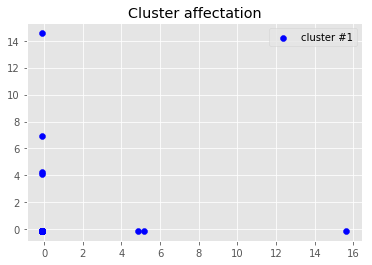

In [25]:
partitions = []

for i in range(0, len(limits)):
    data =  StandardScaler().fit_transform(partitions_tfidf[i])
    gng = GrowingNeuralGas(data)
    
    gng.fit_network(e_b=0.1, e_n=0.006, a_max=10, l=200, a=0.5, d=0.995, passes=8, plot_evolution=True)
    print('Found %d clusters.' % nx.number_connected_components(gng.network))
    gng.plot_clusters(gng.cluster_data())
    print(len(gng.cluster_data()), "x", len(gng.cluster_data()[0]), "x", len(gng.cluster_data()[0][0]))
    print(gng.cluster_data()[0][1])
    # Silhouette
    #silhouette_mean += silhouette_score(partitions_tfidf[i], dash.labels_)

   Pass #1
   Pass #2
   Pass #3
   Pass #4
   Pass #5
   Pass #6
   Pass #7
   Pass #8
   Pass #9
   Pass #10
   Pass #11
   Pass #12
   Pass #13
   Pass #14
   Pass #15
   Pass #16
   Pass #17
   Pass #18
   Pass #19
   Pass #20
   Pass #21
   Pass #22
   Pass #23
   Pass #24
   Pass #25
   Pass #26
   Pass #27
   Pass #28
   Pass #29
   Pass #30
   Pass #31
   Pass #32
   Pass #33
   Pass #34
   Pass #35
   Pass #36
   Pass #37
   Pass #38
   Pass #39
   Pass #40
   Pass #41
   Pass #42
   Pass #43
   Pass #44
   Pass #45
   Pass #46
   Pass #47
   Pass #48
   Pass #49
   Pass #50
   Pass #51
   Pass #52
   Pass #53
   Pass #54
   Pass #55
   Pass #56
   Pass #57
   Pass #58
   Pass #59
   Pass #60
   Pass #61
   Pass #62
   Pass #63
   Pass #64
   Pass #65
   Pass #66
   Pass #67
   Pass #68
   Pass #69
   Pass #70
   Pass #71
   Pass #72
   Pass #73
   Pass #74
   Pass #75
   Pass #76
   Pass #77
   Pass #78
   Pass #79
   Pass #80
   Pass #81
   Pass #82
   Pass #83
   Pass #84
 

   Pass #641
   Pass #642
   Pass #643
   Pass #644
   Pass #645
   Pass #646
   Pass #647
   Pass #648
   Pass #649
   Pass #650
   Pass #651
   Pass #652
   Pass #653
   Pass #654
   Pass #655
   Pass #656
   Pass #657
   Pass #658
   Pass #659
   Pass #660
   Pass #661
   Pass #662
   Pass #663
   Pass #664
   Pass #665
   Pass #666
   Pass #667
   Pass #668
   Pass #669
   Pass #670
   Pass #671
   Pass #672
   Pass #673
   Pass #674
   Pass #675
   Pass #676
   Pass #677
   Pass #678
   Pass #679
   Pass #680
   Pass #681
   Pass #682
   Pass #683
   Pass #684
   Pass #685
   Pass #686
   Pass #687
   Pass #688
   Pass #689
   Pass #690
   Pass #691
   Pass #692
   Pass #693
   Pass #694
   Pass #695
   Pass #696
   Pass #697
   Pass #698
   Pass #699
   Pass #700
   Pass #701
   Pass #702
   Pass #703
   Pass #704
   Pass #705
   Pass #706
   Pass #707
   Pass #708
   Pass #709
   Pass #710
   Pass #711
   Pass #712
   Pass #713
   Pass #714
   Pass #715
   Pass #716
   Pass #717

(array([-0.09059858, -0.09397291,  0.        , ..., -0.07761413,
        -0.06666667, -0.11605542]), 1.0)

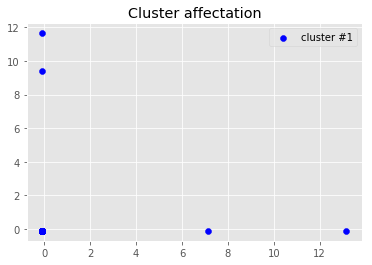

In [27]:
i = 3
data =  StandardScaler().fit_transform(partitions_tfidf[i])
gng = GrowingNeuralGas(data)

gng.fit_network(e_b=0.1, e_n=0.006, a_max=10, l=200, a=0.5, d=0.995, passes=800, plot_evolution=False)
print('Found %d clusters.' % gng.number_of_clusters())
gng.plot_clusters(gng.cluster_data())
print(len(gng.cluster_data()), "x", len(gng.cluster_data()[0]), "x", len(gng.cluster_data()[0][0]))
gng.cluster_data()[0]

# KMeans & Silhouette Score

In [ ]:
# Applying KMeans on tfidf
# the labels_ give assignment of doc to the cluster number 


In [ ]:
# doc_clustering is a dictionnary 
# it looks like -> { doc_number : [partition_number, cluster_number] }
# This is used to reassign doc number to their respective partition and and cluster

def kmeans(nb_clusters):
    doc_clustering = {}
    
    km = KMeans(n_clusters=nb_clusters, max_iter=max_iter)

    # Silhouette score mean
    silhouette_mean = 0

    numDoc = 0
    for i in range(0, len(limits)):
        dash = km.fit(partitions_tfidf[i])

        # Silhouette
        silhouette_mean += silhouette_score(partitions_tfidf[i], dash.labels_)

        previousBound = 0
        if i > 0:
            previousBound = limits[i-1]
        for numDocItern in range(0, limits[i]-previousBound):
            doc_clustering[numDoc] = [i, dash.labels_[numDocItern]]
            numDoc+=1

    silhouette_mean = silhouette_mean / len(limits)
    res = {}
    res["silhouette"] = silhouette_mean
    res["clustering"] = doc_clustering
    return res


In [ ]:
# Compute Silhouette Score for each number of cluster

silhouette_by_cluster_nb = {}

for nbClusters in cluster_ranges:
    print("Computing for", nbClusters, "clusters...")
    silhouette_avg = 0
    for trial in range(0, nb_trial_by_test):
        km = kmeans(nbClusters)
        silhouette_avg += km["silhouette"]
    silhouette_avg = silhouette_avg / nb_trial_by_test
    silhouette_by_cluster_nb[nbClusters] = silhouette_avg

In [ ]:
# We want silhouette scores to be high
silhouette_by_cluster_nb

In [ ]:
doc_clustering = kmeans(nb_cluster)["clustering"]

In [ ]:
# Allows to get list of documents number
# return [dou numbers]
# params : partition_number , cluster number
def get_doc(part, clust):
    docs = []
    for i in range(0,len(doc_clustering)):
        if doc_clustering[i][0] == part and doc_clustering[i][1] == clust:
            docs.append(i)
    return docs

In [ ]:
# Get the partitions variable
# Here partitions[part][cluster] = list of docs numbe
partitions = []
for i in range(0, len(limits)):
    clusters = []
    for j in range(0, nb_clusters):
        clusters.append(get_doc(i,j))
    partitions.append(clusters)

In [ ]:
partitions

# Khi²

In [ ]:
# tf_of_your_word = tf[numDoc][strWord]
tf = []
for doc in usable:
    tf_doc = {}
    for word in vectorizer.get_feature_names():
        tf_doc[word] = doc.count(word)
    tf.append(tf_doc)

In [ ]:
# Number total of words
# nb_total_word[numPartition]
nb_total_word = []
nb = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        nb += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_total_word.append(nb)
        nb=0
    

In [ ]:
nb_total_word

In [ ]:
tf[0]

In [ ]:
# nb_word[num_partition][word]
nb_word = []

word_in_this_parti = {}
for word in vectorizer.get_feature_names():
    word_in_this_parti[word] = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        word_in_this_parti[word] += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_word.append(word_in_this_parti)
        word_in_this_parti = {}
        for word in vectorizer.get_feature_names():
            word_in_this_parti[word] = 0

In [ ]:
len(nb_word)

In [ ]:
# nb_word_by_cluster[numPartition][numCluster]
nb_word_by_cluster = []
for parti in partitions:
    nb_word_clus = []
    for cluster in parti:
        nb = 0
        for numDoc in cluster:
            for word in vectorizer.get_feature_names():
                nb += tf[numDoc][word]
        nb_word_clus.append(nb)
    nb_word_by_cluster.append(nb_word_clus)

In [ ]:
# value_of_khi2 = khi2[numPartition][numCluster][word]
khi2 = []

for numParti in range(0, len(partitions)):
    khi2parti = []
    for numCluster in range(0, len(partitions[numParti])):
        khi2cluster = {}
        
        for word in vectorizer.get_feature_names():
            if nb_word_by_cluster[numParti][numCluster] == 0:
                khi2cluster[word] = 0
            else:
                word_in_this_parti[word] = 0
                E = nb_word[numParti][word]
                E =+ nb_word_by_cluster[numParti][numCluster]
                E = E/ nb_total_word[numParti]
                N = 0
                for numDoc in partitions[numParti][numCluster]:
                    N += tf[numDoc][word]
                khi2cluster[word] = (pow(N - E, 2)/E)        
        khi2parti.append(khi2cluster)
    khi2.append(khi2parti)

In [ ]:
# list of your labels = labels[numPartition][numCluster]
labels = []

for numPartition in range(0, len(nb_word_by_cluster)):
    label_clus = []
    for numCluster in range(0, len(nb_word_by_cluster[numPartition])):
        label_clus.append(Counter(khi2[numPartition][numCluster]).most_common(5))
    labels.append(label_clus)

In [ ]:
# Some clusters can be empty
len(labels[0])

# Diachronic Analysis

In [ ]:

def inter(listA, listB):
    return np.intersect1d(listA, listB)
    
# cluster_t and cluster_s must be in two different partitions
def proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S):
    total_inter = 0
    total_t = 0
    for f in range(0, len(labels[num_partition_T][num_cluster_t])):
        for f_s in labels[num_partition_S][num_cluster_s]:
            if labels[num_partition_T][num_cluster_t][f][0] == f_s[0]:
                total_inter += labels[num_partition_T][num_cluster_t][f][1]
                break
        total_t += labels[num_partition_T][num_cluster_t][f][1]
    if total_t == 0:
        return 0
    return total_inter / total_t
    

def P_A(num_cluster_s, num_partition_T, num_partition_S):
    # first, we have to know what are the cluster which got the label
    total = 0
    nb_computation = 0
    for label_s in labels[num_partition_S][num_cluster_s]:
        for num_cluster_t in range(0, len(partitions[num_partition_T])):
            if label_s in labels[num_partition_T][num_cluster_t]:
                total += proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S)
                nb_computation += 1
    if nb_computation == 0:
        return 0
    return total / nb_computation

# Define a coeficient for the activity 
def activity(num_partition_S, num_partition_T):
    res = 0
    for num_cluster_s in range(0, len(partitions[num_partition_S])):
        res += P_A(num_cluster_s, num_partition_T, num_partition_S)
    return res / len(partitions[num_partition_S])

# Ecart-type, but it isn't very usefull xD
sigma_t = 0.01
sigma_s = 0.01

# Our Graal
def similar(num_cluster_t, num_partition_T, num_cluster_s, num_partition_S):
    cond1 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond2 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_S, num_partition_T) + sigma_s
    
    cond3 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond4 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_T, num_partition_S) + sigma_t
    return cond1 and cond2 and cond3 and cond4
    

In [ ]:
for numParti in range(0, len(partitions)-1):
    for num_cluster_t in range(0, nb_cluster):
        for num_cluster_s in range(0, nb_cluster):
            if similar(num_cluster_t, numParti, num_cluster_s, numParti+1):
                print("("+str(num_cluster_t)+","+str(numParti)+") est similaire à ("+str(num_cluster_s)+","+str(numParti+1)+")")

In [ ]:
print(labels[0][1])
labels[0][1][0][1]